In [190]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
import os

from scipy.special import gamma as gamma

# import custom functions from src folder
module_path = str(Path.cwd() / "../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from util import *

In [191]:
def gamma_distribution(x, shape, scale):
    k = shape
    t = scale
    p_x = x**(k-1)*np.exp(-x/t)/(t**k*gamma(k))
    return p_x

def p_r(r, c, shape_list, scale_list, p_c_list):
    k = len(p_c_list)
    return np.sum([p_r_given_c(r, i, shape_list, scale_list)*p_c_list[i] for i in range(k)], axis=0)

def p_r_given_c(r, c, shape_list, scale_list):
    shape = shape_list[c]
    scale = scale_list[c]
    return gamma_distribution(r, shape, scale)

def p_c_given_r(r, c, shape_list, scale_list, p_c_list):
    return p_r_given_c(r, c, shape_list, scale_list)*p_c_list[c]/p_r(r, c, shape_list, scale_list, p_c_list)

Index(['class', 'r', 'a1', 'a2', 'x1', 'x2', 'x3', 'p_c0', 'p_r_given_c0',
       'p_c0_given_r', 'p_r', 'x1_check', 'x2_check', 'x3_check', 'r_check'],
      dtype='object')


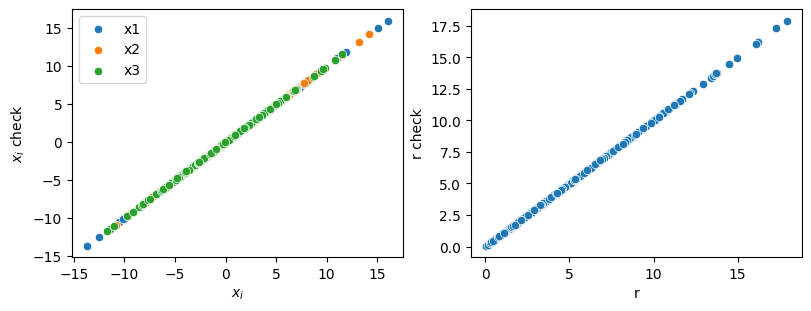

In [192]:
def simulate(shape_list, scale_list, p_c_list, d:int, n:int, seed:int=100):
    rng = np.random.default_rng(seed=seed)
    num_classes = len(scale_list)
    classes = np.arange(0, num_classes)
    c = rng.choice(classes, n, p=p_c_list)
    r = np.zeros(n) # Radii
    a = np.zeros((d, n)) #Angles
    for i in range(num_classes):
        r = np.where(c==i, rng.gamma(shape_list[i], scale_list[i], n), r)
        for j in range(d):
            if j < d-2: #The n-2 first dimensions [0, pi]
                a[j] = rng.uniform(0, np.pi, n)
            else: #The last dimension [0, 2pi]
                a[j] = rng.uniform(0, 2*np.pi, n)
    keys = ["class"]
    df = pd.DataFrame(columns=keys)
    df["class"] = c
    df["r"] = r
    for i in range(0, d-1):
        df[f"a{i+1}"] = a[i]
    df["x1"] = r*np.cos(df[f"a1"]) #x1 = r*cos(a1)
    # Iterate over x_j from j=2 to j=d
    for j in range(2, d+1):
        val = np.ones(n)
        if j == d: # works
            # val = sin(a1*sin(a2)*..*sin(d-2)
            for k in range(1, j-1): # k = 1, ..., j-2
                val = val*np.sin(df[f"a{k}"])
            df[f"x{j}"] = r*val*np.sin(df[f"a{j-1}"])
        else:
            # val = sin(a1*sin(a2)*..*sin(j-1)
            for k in range(1, j): # k = 1, ..., j-2
                val = val*np.sin(df[f"a{k}"])
            df[f"x{j}"] = r*val*np.cos(df[f"a{j}"])
    # Add analytical solution
    for c in range(0, num_classes):
        df[f"p_c{c}"] = p_c_list[c]
        df[f"p_r_given_c{c}"] = p_r_given_c(r, c, shape_list, scale_list)
        df[f"p_c{c}_given_r"] = p_c_given_r(r, c, shape_list, scale_list, p_c_list)
    df[f"p_r"] = p_r(r, c, shape_list, scale_list, p_c_list)
    
    return df

def analytical_grid(shape_list, scale_list, p_c_list, d:int, nx:int=100, rmax:float=30.0):
    #Just implement for 2D for now
    keys = ["r"]
    df = pd.DataFrame(columns=keys)
    num_classes = len(p_c_list)
    if d == 2:
        x1 = np.linspace(-rmax, rmax, nx)
        x2 = np.linspace(-rmax, rmax, nx)
        xx1, xx2 = np.meshgrid(x1, x2)
        df = pd.DataFrame(columns = ["x1", "x2"], index = range(len(xx1.flatten())))
        df["x1"] = xx1.flatten()
        df["x2"] = xx2.flatten()
        df = cartesian_to_polar_df(df, "x1", "x2", "r", "a1") # From util
        # Calculate probabilities
        for c in range(0, num_classes):
            df[f"p_c{c}"] = p_c_list[c]
            df[f"p_r_given_c{c}"] = p_r_given_c(df["r"], c, shape_list, scale_list)
            df[f"p_c{c}_given_r"] = p_c_given_r(df["r"], c, shape_list, scale_list, p_c_list)
        df[f"p_r"] = p_r(df["r"], c, shape_list, scale_list, p_c_list)
        return df
    else:
        print("Not supported for d != 2 yet...")
        return df


def test_polar_coordinates():
    #Test that it works in 3D
    shapes = [2]
    scales = [2]
    k = len(scales) # Number of classes
    d = 3 # Number of dimensions
    p_c = [1/len(shapes)]*len(shapes) # Uniform distributon over classes
    seed = 24
    df = simulate(shapes, scales, p_c, d, n=1000, seed=seed)
    #a1 = theta, [0, pi]
    #a2 = phi, [0, 2pi]
    df["x1_check"] = df["r"]*np.cos(df["a1"])
    df["x2_check"] = df["r"]*np.sin(df["a1"])*np.cos(df["a2"])
    df["x3_check"] = df["r"]*np.sin(df["a1"])*np.sin(df["a2"])
    df["r_check"] = np.sqrt(df["x1"]**2+df["x2"]**2+df["x3"]**2)
    print(df.keys())
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (8, 3), layout="constrained")
    for i in range(1, d+1):
        sn.scatterplot(df, x=f"x{i}", y = f"x{i}_check", label=f"x{i}", ax=axs[0])
    axs[0].set_xlabel(r"$x_i$")
    axs[0].set_ylabel(r"$x_i$ check")
    sn.scatterplot(df, x="r", y="r_check", ax=axs[1])
    axs[1].set_ylabel(r"r check")

test_polar_coordinates()

In [206]:
SAVE = True
# Choose parameters
shapes = [2, 2]
scales = [5, 3]
k = len(scales) # Number of classes
d = 2 # Number of dimensions
p_c = [0.5, 0.5]
#[1/len(shapes)]*len(shapes) # Uniform distributon over classes
seed = 24
grid_rmax=20

train_df = simulate(shapes, scales, p_c, d=d, n=50000, seed=seed)
test_df = simulate(shapes, scales, p_c, d=d, n=10000, seed=seed)
val_df = simulate(shapes, scales, p_c, d=d, n=5000, seed=seed)
grid_df = analytical_grid(shapes, scales, p_c, d, nx=100, rmax=grid_rmax)

In [207]:
train_df.keys()

Index(['class', 'r', 'a1', 'x1', 'x2', 'p_c0', 'p_r_given_c0', 'p_c0_given_r',
       'p_c1', 'p_r_given_c1', 'p_c1_given_r', 'p_r'],
      dtype='object')

In [208]:
# Save data only if it does not already exist
def save_file(df, filename):
    if os.path.isfile(filename):
        print("File already exists. To replace, manually override.")
    else:
        df.to_csv(filename, index=False)

tag = f'k_{k}_d{d}_shapes{shapes}_scales{scales}_pc{p_c}'.replace(" ", "")
if SAVE:
    trainfile = f'data/train_n_{len(train_df)}_{tag}.csv'
    save_file(train_df, trainfile)
    valfile = f'data/val_n_{len(val_df)}_{tag}.csv'
    save_file(val_df, valfile)
    testfile = f'data/test_n_{len(test_df)}_{tag}.csv'
    save_file(test_df, testfile)
    if len(grid_df) > 0:
        gridfile = f'data/grid_x1_x2_{len(grid_df)}_{tag}.csv'
        save_file(grid_df, gridfile)


Text(0.5, 0.98, 'Training data')

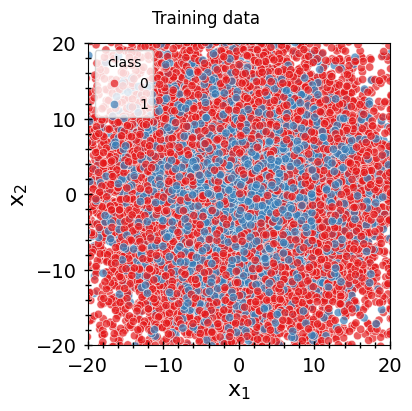

In [209]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (4, 4), layout="constrained")
color = ["#e41a1c", "#377eb8"]
sn.scatterplot(train_df, x="x1", y="x2", hue="class", palette=color,
               alpha=0.7, ax = ax)
ax.set_xlabel(r"x$_1$", fontsize=16)
ax.set_ylabel(r"x$_2$", fontsize=16)
ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
ax.tick_params(which="major", length=6)
ax.minorticks_on()
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-grid_rmax, grid_rmax)
ax.set_ylim(-grid_rmax, grid_rmax)
fig.suptitle("Training data")

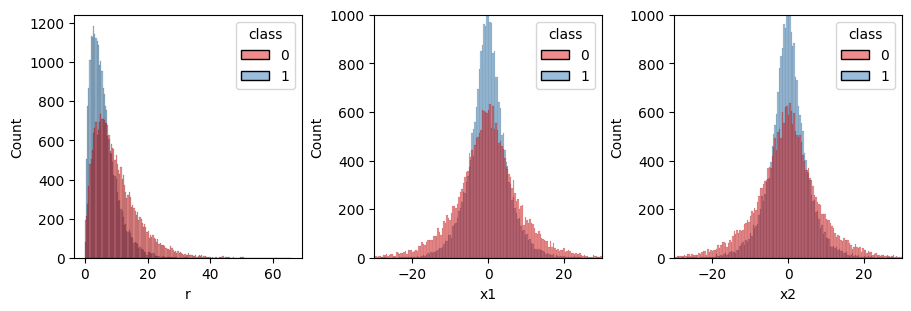

In [210]:
fig, axs = plt.subplots(nrows=1, ncols=d+1, figsize= (3*(d+1), 3), layout="constrained")
sn.histplot(train_df, x=f"r", hue="class", palette=color, ax = axs[0])
for i in range(1, d+1):
    sn.histplot(train_df, x=f"x{i}", hue="class", palette=color, ax = axs[i])
    axs[i].set_ylim(0, 1000)
    axs[i].set_xlim(-30, 30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


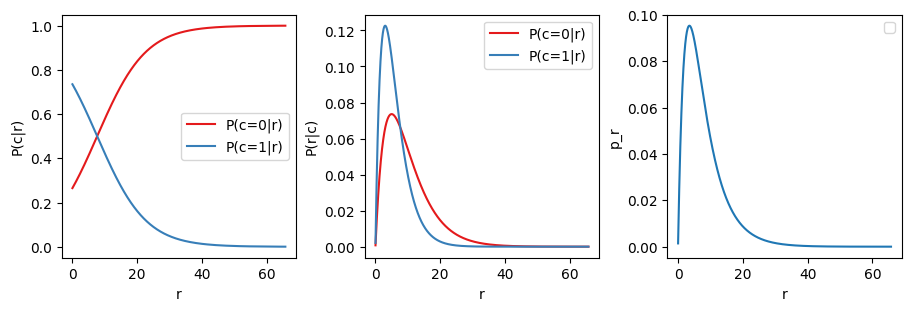

In [211]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), layout="constrained")
for i in range(k):
    sn.lineplot(train_df, x="r", y=f"p_c{i}_given_r", label=f"P(c={i}|r)", ax=axs[0], c=color[i])
    axs[0].set_ylabel(r"P(c|r)")
    sn.lineplot(train_df, x="r", y=f"p_r_given_c{i}", label=f"P(c={i}|r)", ax=axs[1], c=color[i])
    axs[1].set_ylabel(r"P(r|c)")

sn.lineplot(train_df, x="r", y="p_r", ax=axs[2])
for ax in axs:
    ax.legend()
    ax.set_xlabel("r")
    #ax.set_xlim(0, 30)



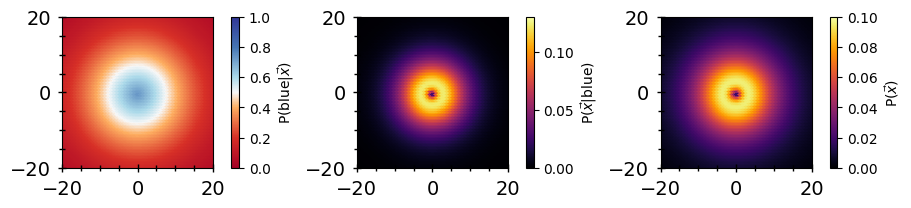

In [212]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 4), layout="constrained")

axs[0] = plot_results(grid_df, "p_c1_given_r", axs[0], "", grid=True, rmax=grid_rmax)
hue_norm_prob = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_prob, cmap=red_blue_cmap()),  fraction=0.050, pad=0.04,
                 label=r"P(blue|$\vec{x}$)", ax=axs[0])

axs[1] = plot_std(grid_df, "p_r_given_c1", axs[1], "", max_val=0.13, grid=True, rmax=grid_rmax)

hue_norm_prob = mpl.colors.Normalize(vmin=0, vmax=0.13, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_prob, cmap="inferno"),  fraction=0.050, pad=0.04,
                 label=r"P($\vec{x}$|blue)", ax=axs[1])

axs[2] = plot_std(grid_df, "p_r", axs[2], "", max_val=0.10, grid=True, rmax=grid_rmax)

hue_norm_prob = mpl.colors.Normalize(vmin=0, vmax=0.10, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_prob, cmap="inferno"),  fraction=0.050, pad=0.04,
                 label=r"P($\vec{x}$)", ax=axs[2])

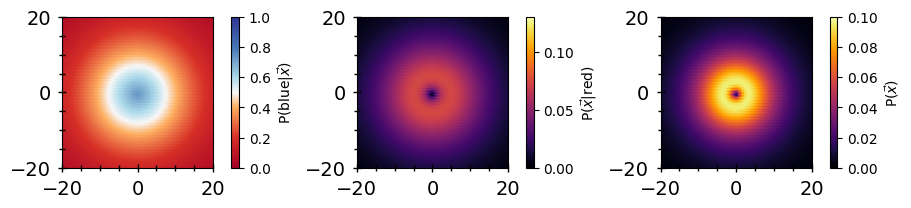

In [213]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 4), layout="constrained")

axs[0] = plot_results(grid_df, "p_c1_given_r", axs[0], "", grid=True, rmax=grid_rmax)
hue_norm_prob = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_prob, cmap=red_blue_cmap()),  fraction=0.050, pad=0.04,
                 label=r"P(blue|$\vec{x}$)", ax=axs[0])

axs[1] = plot_std(grid_df, "p_r_given_c0", axs[1], "", max_val=0.13, grid=True, rmax=grid_rmax)

hue_norm_prob = mpl.colors.Normalize(vmin=0, vmax=0.13, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_prob, cmap="inferno"),  fraction=0.050, pad=0.04,
                 label=r"P($\vec{x}$|red)", ax=axs[1])

axs[2] = plot_std(grid_df, "p_r", axs[2], "", max_val=0.1, grid=True, rmax=grid_rmax)

hue_norm_prob = mpl.colors.Normalize(vmin=0, vmax=0.1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_prob, cmap="inferno"),  fraction=0.050, pad=0.04,
                 label=r"P($\vec{x}$)", ax=axs[2])